In [1]:
!nvidia-smi

Wed Jul 15 06:57:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import numpy as rnp
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def loss(X,w,y):
  yhat = X@w
  return (np.linalg.norm(y-yhat)**2) #/(2*y.shape[0])

In [4]:
grad_loss = jit(grad(loss, argnums=1))

In [5]:
def smd_update(i,w,X,y,lr=0.001,p=2,decay=1):
  dw = grad_loss(X,w,y)
  update = p*((np.abs(w))**(p-1))*np.sign(w) - lr*(decay)**i*dw
  w_ = (np.abs(update/p)**(1/(p-1)))*np.sign(update)

  return w_

In [6]:
d = 1000

In [7]:
def generate_data(n=100,d=d):
  X = rnp.random.random(size=(n,d))
  for i in range(n):
    X[i] = X[i]/rnp.linalg.norm(X[i])
  
  w_gold = rnp.random.random(size=d)
  y = X@w_gold

  y = rnp.random.random(size=n)
  assert rnp.linalg.matrix_rank(X) == n
  return X,y,w_gold

# **Experiment 1**
## hist of different p-norm SMD for a given parameterization ratio
## convegence rate of different p-norm SMD for a given parameterization ratio

In [8]:
X, y, w_gold = generate_data()

In [9]:
a,_,_,_ = np.linalg.lstsq(X,y)
print(np.linalg.norm(X@w_gold-y))
print(np.linalg.norm(X@a-y))
print(np.linalg.norm(a-w_gold))

133.34274
3.152873e-06
18.662031


In [10]:
lr_dict = {1.1:0.01,2:0.01,3:.001, 10:0.0001}
decay_dict = {1.1:1,2:1,3:1,10:0.999}

In [11]:
norms = [1.1,2,3,10]
epochs = 10000
L = rnp.zeros((len(norms),epochs))
weights = rnp.zeros((len(norms),d))
w_init = rnp.random.normal(loc=0,scale=1e-2,size=d)
for k, norm in enumerate(norms):
  print('norm:{}'.format(norm))
  l = rnp.zeros(epochs)
  w = w_init.copy()
  for i in tqdm(range(epochs)):
    l[i] = loss(X,w,y)
    w = smd_update(i,w,X,y,lr=lr_dict[norm],p=norm, decay=decay_dict[norm])
    if i%1000 == 0:
      print('Epoch:{}, Loss:{}'.format(i,l[i]))
  # if norm < 5.0:
  #   for i in tqdm(range(epochs)):
  #     l[i] = loss(X,w,y)
  #     w = smd_update(i,w,X,y,lr=0.01,p=norm, decay=1)
  #     if i%1000 == 0:
  #       print('Epoch:{}, Loss:{}'.format(i,l[i]))
  # else:
  #   for i in tqdm(range(epochs)):
  #     l[i] = loss(X,w,y)
  #     w = smd_update(i,w,X,y,lr=0.0001,p=norm, decay=0.999)
  #     if i%1000 == 0:
  #       print('Epoch:{}, Loss:{}'.format(i,l[i]))

  L[k] = l
  weights[k] = w

  0%|          | 0/10000 [00:00<?, ?it/s]

norm:1.1


  0%|          | 21/10000 [00:00<1:14:17,  2.24it/s]

Epoch:0, Loss:32.122344970703125


 10%|█         | 1021/10000 [00:05<00:45, 197.25it/s]

Epoch:1000, Loss:0.03395462781190872


 20%|██        | 2036/10000 [00:11<00:41, 193.95it/s]

Epoch:2000, Loss:0.0010838857851922512


 30%|███       | 3034/10000 [00:16<00:35, 194.23it/s]

Epoch:3000, Loss:7.496456237277016e-05


 40%|████      | 4033/10000 [00:21<00:31, 190.38it/s]

Epoch:4000, Loss:6.891663815622451e-06


 50%|█████     | 5035/10000 [00:26<00:27, 183.65it/s]

Epoch:5000, Loss:8.508087034897471e-07


 60%|██████    | 6038/10000 [00:31<00:20, 191.84it/s]

Epoch:6000, Loss:2.400190624030074e-07


 70%|███████   | 7036/10000 [00:37<00:15, 193.47it/s]

Epoch:7000, Loss:1.5335770342517208e-07


 80%|████████  | 8021/10000 [00:42<00:10, 187.32it/s]

Epoch:8000, Loss:1.26490419916081e-07


 90%|█████████ | 9036/10000 [00:47<00:05, 191.30it/s]

Epoch:9000, Loss:1.1453935400140836e-07


  0%|          | 19/10000 [00:00<00:55, 180.81it/s]

norm:2
Epoch:0, Loss:32.122344970703125


 10%|█         | 1030/10000 [00:05<00:45, 196.29it/s]

Epoch:1000, Loss:0.11274100095033646


 20%|██        | 2027/10000 [00:09<00:40, 196.92it/s]

Epoch:2000, Loss:0.004128112457692623


 30%|███       | 3027/10000 [00:14<00:33, 205.97it/s]

Epoch:3000, Loss:0.0002109610941261053


 40%|████      | 4036/10000 [00:19<00:29, 203.14it/s]

Epoch:4000, Loss:1.2779839380527847e-05


 50%|█████     | 5032/10000 [00:24<00:23, 213.15it/s]

Epoch:5000, Loss:8.707350502845657e-07


 60%|██████    | 6035/10000 [00:29<00:18, 210.36it/s]

Epoch:6000, Loss:7.242741162372113e-08


 70%|███████   | 7031/10000 [00:34<00:15, 195.43it/s]

Epoch:7000, Loss:1.5299118416578494e-08


 80%|████████  | 8028/10000 [00:38<00:09, 197.58it/s]

Epoch:8000, Loss:8.828243913683309e-09


 90%|█████████ | 9042/10000 [00:44<00:04, 199.87it/s]

Epoch:9000, Loss:7.266988344412084e-09


  0%|          | 7/10000 [00:00<02:22, 69.96it/s]

norm:3
Epoch:0, Loss:32.122344970703125


 10%|█         | 1035/10000 [00:05<00:48, 183.23it/s]

Epoch:1000, Loss:1.2955750226974487


 20%|██        | 2025/10000 [00:10<00:44, 178.68it/s]

Epoch:2000, Loss:0.5478842854499817


 30%|███       | 3022/10000 [00:16<00:35, 197.24it/s]

Epoch:3000, Loss:0.26859572529792786


 40%|████      | 4024/10000 [00:21<00:30, 194.77it/s]

Epoch:4000, Loss:0.14140203595161438


 50%|█████     | 5034/10000 [00:26<00:24, 203.13it/s]

Epoch:5000, Loss:0.07765280455350876


 60%|██████    | 6026/10000 [00:31<00:20, 197.92it/s]

Epoch:6000, Loss:0.043876588344573975


 70%|███████   | 7043/10000 [00:36<00:14, 210.19it/s]

Epoch:7000, Loss:0.025271067395806313


 80%|████████  | 8039/10000 [00:41<00:09, 208.73it/s]

Epoch:8000, Loss:0.01475916150957346


 90%|█████████ | 9037/10000 [00:46<00:04, 204.68it/s]

Epoch:9000, Loss:0.008698541671037674


  0%|          | 6/10000 [00:00<02:53, 57.77it/s]

norm:10
Epoch:0, Loss:32.122344970703125


 10%|█         | 1025/10000 [00:05<00:44, 202.73it/s]

Epoch:1000, Loss:1293.2274169921875


 20%|██        | 2025/10000 [00:10<00:41, 193.51it/s]

Epoch:2000, Loss:182.5935516357422


 30%|███       | 3024/10000 [00:15<00:35, 196.10it/s]

Epoch:3000, Loss:4.10852575302124


 40%|████      | 4042/10000 [00:20<00:30, 198.52it/s]

Epoch:4000, Loss:0.2723035216331482


 50%|█████     | 5022/10000 [00:25<00:24, 199.33it/s]

Epoch:5000, Loss:2.779566764831543


 60%|██████    | 6041/10000 [00:30<00:18, 210.96it/s]

Epoch:6000, Loss:1.84625244140625


 70%|███████   | 7021/10000 [00:34<00:15, 197.97it/s]

Epoch:7000, Loss:1.2036441564559937


 80%|████████  | 8027/10000 [00:40<00:10, 188.45it/s]

Epoch:8000, Loss:0.6823225617408752


 90%|█████████ | 9041/10000 [00:45<00:04, 199.50it/s]

Epoch:9000, Loss:0.12187690287828445


100%|██████████| 10000/10000 [00:49<00:00, 200.24it/s]


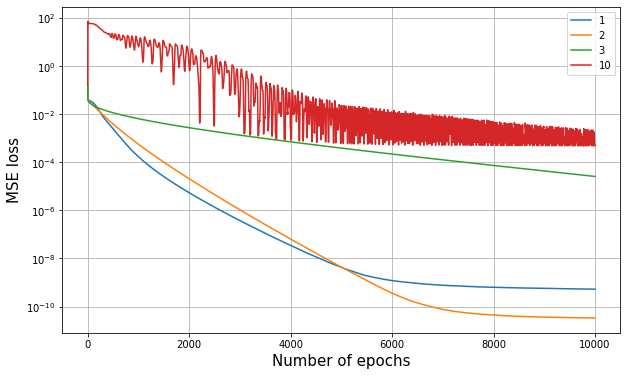

In [12]:
# L = L/(2*y.shape[0])
plt.figure(figsize=(10,6))
plt.xlabel('Number of epochs',size=15)
plt.ylabel('MSE loss',size=15)
for i in range(L.shape[0]):
  if norms[i] == 1.1:
    norms[i] = 1
  plt.semilogy(L[i]/(2*y.shape[0]),label=norms[i])


plt.grid(True)
plt.legend()
plt.savefig('lr_curve.svg',format='svg')
plt.show()

In [13]:
(rnp.abs(weights[0]) > 1.5).sum()

11

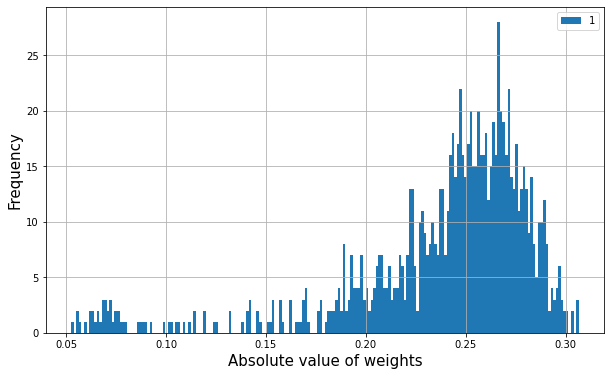

In [17]:
plt.figure(figsize=(10,6))
plt.xlabel('Absolute value of weights',size=15)
plt.ylabel('Frequency',size=15)
# plt.yscale('log', nonposy='clip')

plt.hist(np.abs(weights[3]), bins=200, label=norms[0])
# for i in range(weights.shape[0]):
#   plt.hist(np.abs(weights[2]), bins=200, label=norms[i])
# plt.hist(np.abs(w_init),bins=100, label='init')

plt.grid()
plt.legend()
plt.show()

# **Experiment 2**
## hist of weights for different parameterization
## convergence rates for different parameterization


In [8]:
n_data = [1,10,100,500,1000]
epochs = 10000
norm = 10
L = rnp.zeros((len(n_data),epochs))
weights = rnp.zeros((len(n_data),d))
w_init = rnp.random.normal(loc=0,scale=1e-2,size=d)

lr_dict_n = {1.1:{1:0.01,10:0.01,100:0.01,500:0.001,1000:0.0001},
             2:{1:0.01,10:0.01,100:0.01,500:0.001,1000:0.001},
             3:{1:0.01,10:0.01,100:0.001,500:0.001,1000:0.001},
             10:{1:0.0001,10:0.0001,100:0.0001,500:0.0001,1000:0.0001}}
decay_dict_n = {1.1:{1:1,10:1,100:1,500:0.9999,1000:0.9999},
             2:{1:1,10:1,100:1,500:1,1000:1},
             3:{1:1,10:1,100:1,500:1,1000:1},
             10:{1:0.999,10:0.999,100:0.999,500:0.999,1000:0.999}}

min_error = 1e-12
for k, n in enumerate(n_data):
  X, y,_ = generate_data(n=n)
  print('n:{}'.format(n))
  l = rnp.zeros(epochs)
  w = w_init.copy()
  for i in tqdm(range(epochs)):
    l[i] = loss(X,w,y)
    if l[i] > min_error:
      w = smd_update(i,w,X,y,lr=lr_dict_n[norm][n],p=norm, decay=decay_dict_n[norm][n])
    else:
      continue
    if i%1000 == 0:
      print('Epoch:{}, Loss:{}'.format(i,l[i]))
  L[k] = l
  weights[k] = w

  0%|          | 0/10000 [00:00<?, ?it/s]

n:1


  0%|          | 2/10000 [00:01<3:36:31,  1.30s/it]

Epoch:0, Loss:0.43239957094192505


 10%|█         | 1033/10000 [00:06<00:40, 223.60it/s]

Epoch:1000, Loss:28.760387420654297


 20%|██        | 2038/10000 [00:10<00:34, 229.87it/s]

Epoch:2000, Loss:21.7168025970459


 30%|███       | 3046/10000 [00:15<00:30, 230.58it/s]

Epoch:3000, Loss:16.28093910217285


 40%|████      | 4028/10000 [00:19<00:24, 244.63it/s]

Epoch:4000, Loss:9.443926811218262


 50%|█████     | 5041/10000 [00:23<00:21, 230.11it/s]

Epoch:5000, Loss:9.105257034301758


 60%|██████    | 6041/10000 [00:27<00:16, 244.98it/s]

Epoch:6000, Loss:6.756126880645752


 70%|███████   | 7030/10000 [00:32<00:12, 239.56it/s]

Epoch:7000, Loss:4.834138870239258


 80%|████████  | 8031/10000 [00:36<00:08, 228.33it/s]

Epoch:8000, Loss:9.037114143371582


 90%|█████████ | 9036/10000 [00:40<00:04, 238.48it/s]

Epoch:9000, Loss:3.1978166103363037


  0%|          | 0/10000 [00:00<?, ?it/s]

n:10


  0%|          | 2/10000 [00:00<47:59,  3.47it/s]

Epoch:0, Loss:3.1287248134613037


 10%|█         | 1036/10000 [00:05<00:39, 227.65it/s]

Epoch:1000, Loss:440.2536926269531


 20%|██        | 2038/10000 [00:09<00:36, 218.97it/s]

Epoch:2000, Loss:330.1554260253906


 30%|███       | 3030/10000 [00:14<00:32, 215.06it/s]

Epoch:3000, Loss:241.70909118652344


 40%|████      | 4043/10000 [00:18<00:27, 215.04it/s]

Epoch:4000, Loss:175.86634826660156


 50%|█████     | 5030/10000 [00:23<00:24, 202.64it/s]

Epoch:5000, Loss:125.6014175415039


 60%|██████    | 6038/10000 [00:28<00:18, 218.52it/s]

Epoch:6000, Loss:88.68572235107422


 70%|███████   | 7039/10000 [00:32<00:13, 222.42it/s]

Epoch:7000, Loss:59.08116912841797


 80%|████████  | 8018/10000 [00:37<00:09, 208.20it/s]

Epoch:8000, Loss:37.731021881103516


 90%|█████████ | 9046/10000 [00:41<00:04, 222.40it/s]

Epoch:9000, Loss:18.131118774414062


  0%|          | 0/10000 [00:00<?, ?it/s]

n:100


  0%|          | 7/10000 [00:00<33:59,  4.90it/s]

Epoch:0, Loss:34.326622009277344


 10%|█         | 1030/10000 [00:05<00:44, 200.22it/s]

Epoch:1000, Loss:3089.49365234375


 20%|██        | 2032/10000 [00:10<00:38, 208.55it/s]

Epoch:2000, Loss:188.41119384765625


 30%|███       | 3028/10000 [00:15<00:35, 196.24it/s]

Epoch:3000, Loss:2.4665658473968506


 40%|████      | 4035/10000 [00:20<00:30, 198.79it/s]

Epoch:4000, Loss:8.394241333007812


 50%|█████     | 5029/10000 [00:25<00:25, 197.07it/s]

Epoch:5000, Loss:4.167567729949951


 60%|██████    | 6035/10000 [00:30<00:19, 201.08it/s]

Epoch:6000, Loss:0.6643280982971191


 70%|███████   | 7034/10000 [00:35<00:15, 195.40it/s]

Epoch:7000, Loss:0.688264787197113


 80%|████████  | 8037/10000 [00:40<00:09, 207.89it/s]

Epoch:8000, Loss:0.12832988798618317


 90%|█████████ | 9025/10000 [00:45<00:05, 175.73it/s]

Epoch:9000, Loss:0.40032026171684265


  0%|          | 0/10000 [00:00<?, ?it/s]

n:500


  0%|          | 4/10000 [00:00<39:46,  4.19it/s]

Epoch:0, Loss:169.75050354003906


 10%|█         | 1033/10000 [00:06<00:54, 164.03it/s]

Epoch:1000, Loss:2314.571533203125


 20%|██        | 2032/10000 [00:12<00:47, 166.82it/s]

Epoch:2000, Loss:115.83998107910156


 30%|███       | 3022/10000 [00:18<00:43, 160.81it/s]

Epoch:3000, Loss:10.836568832397461


 40%|████      | 4019/10000 [00:24<00:33, 180.17it/s]

Epoch:4000, Loss:78.03705596923828


 50%|█████     | 5019/10000 [00:30<00:27, 181.11it/s]

Epoch:5000, Loss:38.014522552490234


 60%|██████    | 6032/10000 [00:36<00:24, 160.71it/s]

Epoch:6000, Loss:66.75779724121094


 70%|███████   | 7021/10000 [00:42<00:19, 155.05it/s]

Epoch:7000, Loss:10.826003074645996


 80%|████████  | 8034/10000 [00:48<00:11, 169.63it/s]

Epoch:8000, Loss:5.305979251861572


 90%|█████████ | 9034/10000 [00:54<00:05, 174.09it/s]

Epoch:9000, Loss:4.855282306671143


  0%|          | 0/10000 [00:00<?, ?it/s]

n:1000


  0%|          | 5/10000 [00:00<38:50,  4.29it/s]

Epoch:0, Loss:320.3197937011719


 10%|█         | 1023/10000 [00:07<01:00, 147.36it/s]

Epoch:1000, Loss:4070.57080078125


 20%|██        | 2022/10000 [00:14<00:56, 139.99it/s]

Epoch:2000, Loss:2120.71728515625


 30%|███       | 3011/10000 [00:21<00:49, 140.45it/s]

Epoch:3000, Loss:40.10508728027344


 40%|████      | 4025/10000 [00:28<00:45, 130.95it/s]

Epoch:4000, Loss:544.6043701171875


 50%|█████     | 5029/10000 [00:36<00:35, 140.92it/s]

Epoch:5000, Loss:725.09228515625


 60%|██████    | 6019/10000 [00:43<00:27, 145.26it/s]

Epoch:6000, Loss:200.98793029785156


 70%|███████   | 7019/10000 [00:50<00:19, 149.28it/s]

Epoch:7000, Loss:100.9267807006836


 80%|████████  | 8028/10000 [00:57<00:13, 146.97it/s]

Epoch:8000, Loss:60.82745361328125


 90%|█████████ | 9028/10000 [01:04<00:07, 138.12it/s]

Epoch:9000, Loss:87.31464385986328


100%|██████████| 10000/10000 [01:11<00:00, 139.44it/s]


is there a particular parametrization ratio for which the linear model performs the best(least error)? or it is a monotonic relation? For p=3, kappa = 0.001 performs best. For p=2, kappa = 0.001 performs best. For p=1, kappa = 0.1 performs best.

In [9]:
print(L[:,-1])
L1 = (L.T / n_data).T
L1 = L1*0.5
L1[:,-1]

[3.87928085e-05 5.89135016e-05 1.86316639e-01 5.98307276e+00
 4.61769257e+01]


array([1.93964042e-05, 2.94567508e-06, 9.31583196e-04, 5.98307276e-03,
       2.30884628e-02])

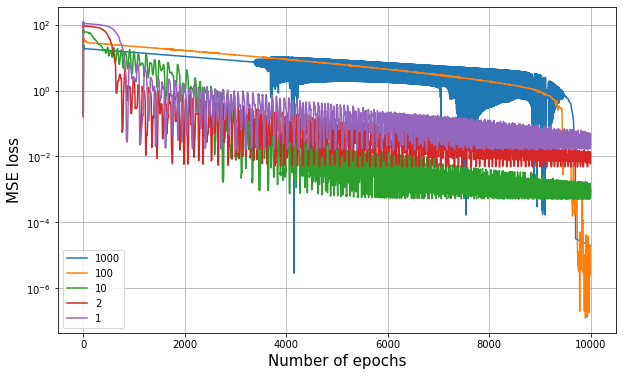

In [10]:
plt.figure(figsize=(10,6))
plt.xlabel('Number of epochs',size=15)
plt.ylabel('MSE loss',size=15)
for i in range(L.shape[0]):
  plt.semilogy(np.arange(epochs), L1[i],label=int(d/n_data[i]))

plt.grid(True)
plt.legend()
plt.show()

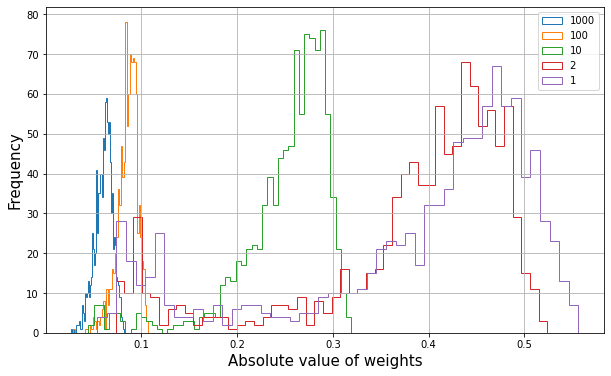

In [11]:
plt.figure(figsize=(10,6))
plt.xlabel('Absolute value of weights',size=15)
plt.ylabel('Frequency',size=15)
for i in range(weights.shape[0]):
  plt.hist(np.abs(weights[i]), bins=50, label=int(d/n_data[i]), cumulative=False, histtype='step')

# plt.yscale('log', nonposy='clip')
plt.grid()
plt.legend()
plt.show()

the maximum absolute value of the weights is inversely proportional to kappa value (parameterization ratio performs some form of L2-regularization?) The weights finally converge to some upper limit.

# **Experiments for Non-Linear Models (CIFAR-10)**
## Courtsey: Sahin Lale, Caltech

In [ ]:
!nvidia-smi

Tue Jul 14 13:22:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    71W / 149W |  10661MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
from torch.optim import Optimizer
import torch.distributed as dist
from torch._utils import _flatten_dense_tensors, _unflatten_dense_tensors, \
    _take_tensors
import math


class SMD_compress(Optimizer):

    def __init__(self, params, lr=0.01, momentum=0, weight_decay = 0, dampening=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= momentum:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, dampening=dampening)
        super(SMD_compress, self).__init__(params, defaults)
    
    def __setstate__(self, state):
        super(SMD_compress, self).__setstate__(state)
    
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            
#             all_grads = []

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    d_p = buf
    #           (1+eps) norm potential function
                eps = 0.1
                update = (1+eps)* (torch.abs(p.data)**eps) * torch.sign(p.data) - group['lr'] * d_p
                p.data = (torch.abs(update/(1+eps))**(1/eps)) * torch.sign(update)

        return loss 
    

class SMD_qnorm(Optimizer):

    def __init__(self, params, lr=0.01, momentum=0, weight_decay = 0, dampening=0, q =3):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= momentum:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if not 2.0 <= q:
            raise ValueError("Invalid q_norm value: {}".format(q))

        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, dampening=dampening, q = q)
        super(SMD_qnorm, self).__init__(params, defaults)
    
    def __setstate__(self, state):
        super(SMD_qnorm, self).__setstate__(state)
    
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            
#             all_grads = []

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
    #           q norm potential function
                update = (group['q'])* (torch.abs(p.data)**(group['q']-1)) * torch.sign(p.data) - group['lr'] * d_p
                p.data = (torch.abs(update/(group['q']))**(1/(group['q'] - 1))) * torch.sign(update)

        return loss 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import math
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models as models
# import SMD_opt

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms




num_epochs = 4500
num_classes = 10
batch_size = 128
learning_rate = 0.01

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')

model = ResNet18()

if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
model = model.cuda()

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.0, 0.01)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.uniform_(-0.01, 0.01)
        m.bias.data.uniform_(-0.1, 0.1)
    
model.apply(weights_init)

free_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable parameters:',free_params)


criterion = nn.CrossEntropyLoss().cuda()
optimizer = SMD_compress(model.parameters(), lr=learning_rate)

total_step = len(trainloader)
print('Total steps:',total_step)
loss_list = []
acc_list = []

# Training
resume = True
last_epoch = 100
PATH = '/content/drive/My Drive/smd1_' + str(last_epoch) + '.pth'
if resume:
    print('Resuming model training from {} epochs...'.format(last_epoch))
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

for epoch in range(num_epochs):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.cuda(async=True)
        labels = labels.cuda(async=True)
        
        images = Variable(images)
        labels = Variable(labels)
        # Run the forward pass
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

         # Track the accuracy
        total = labels.size(0) + total
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item() + correct
        acc_list.append(correct / total)
        
        if (i + 1) % 100 == 0:
            w = torch.nn.utils.parameters_to_vector(model.parameters())
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
    if (correct/total) > 0.999 :
        break
    if epoch % 100 == 0 and epoch > 0:
        checkpoint = {'epoch': epoch,
                      'loss': loss,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict()}
        torch.save(checkpoint, '/content/drive/My Drive/smd1_' + str(epoch) + '.pth')
        print('Saving model after {} epochs as smd1_{}.pth'.format(epoch, epoch))
        

print('Finished Training')


torch.save(model.state_dict(), './final_1norm.pth') 

# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.cuda(async=True)
        labels = labels.cuda(async=True)
        
        images = Variable(images)
        labels = Variable(labels)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

==> Preparing data..


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
==> Building model..
Trainable parameters: 11173962
Total steps: 391
Resuming model training from 100 epochs...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of cuda is deprecated:
	cuda(torch.device device, bool async, *, torch.memory_format memory_format)
Consider using one of the following signatures instead:
	cuda(torch.device device, bool non_blocking, *, torch.memory_format memory_format)


Epoch [1/4500], Step [100/391], Loss: 0.0018, Accuracy: 99.92%
Epoch [1/4500], Step [200/391], Loss: 0.0008, Accuracy: 99.91%
Epoch [1/4500], Step [300/391], Loss: 0.0015, Accuracy: 99.91%
Finished Training
Test Accuracy of the model on the 10000 test images: 89.67 %


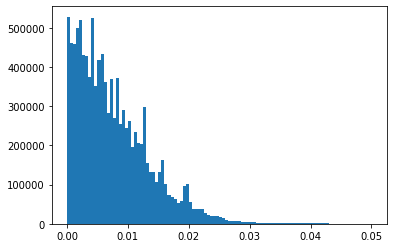

In [ ]:
w_ = w.detach().cpu().numpy()
np.save('smd1',w_)
lim = 0.05
import numpy as np
import matplotlib.pyplot as plt
wabs = np.abs(w_)
id = np.where(wabs <= lim)
w1 = wabs[id]
plt.hist(w1, bins=100)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import math
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models as models
# import SMD_opt

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms




num_epochs = 4500
num_classes = 10
batch_size = 128
learning_rate = 0.02

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')

model = ResNet18()

if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
model = model.cuda()

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.0, 0.01)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.weight.data.uniform_(-0.01, 0.01)
        m.bias.data.uniform_(-0.1, 0.1)
    
model.apply(weights_init)

free_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(free_params)


criterion = nn.CrossEntropyLoss().cuda()
optimizer = SMD_qnorm(model.parameters(), lr=learning_rate, q=10)

total_step = len(trainloader)
print(total_step)
loss_list = []
acc_list = []


# Training
resume = True
last_epoch = 100
PATH = '/content/drive/My Drive/smd10_' + str(last_epoch) + '.pth'
if resume:
    print('Resuming model training from {} epochs...'.format(last_epoch))
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

for epoch in range(num_epochs):
    total = 0
    correct = 0
#     scheduler.step()
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.cuda(async=True)
        labels = labels.cuda(async=True)
        
        images = Variable(images)
        labels = Variable(labels)
        # Run the forward pass
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

         # Track the accuracy
        total = labels.size(0) + total
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item() + correct
        acc_list.append(correct / total)
        
        if (i + 1) % 100 == 0:
            w = torch.nn.utils.parameters_to_vector(model.parameters())
            # print(w)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
    if (correct/total) >= 0.999 :
        break 
    if epoch % 100 == 0 and epoch > 0:
        checkpoint = {'epoch': epoch,
                      'loss': loss,
                      'model_state_dict': model.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict()}
        torch.save(checkpoint, '/content/drive/My Drive/smd10_' + str(epoch) + '.pth')
        print('Saving model after {} epochs as smd10_{}.pth'.format(epoch, epoch))

print('Finished Training')




torch.save(model.state_dict(), './final_10norm.pth') 


# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.cuda(async=True)
        labels = labels.cuda(async=True)
        
        images = Variable(images)
        labels = Variable(labels)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
11173962
391
Epoch [1/4500], Step [100/391], Loss: 1.9088, Accuracy: 19.51%
Epoch [1/4500], Step [200/391], Loss: 2.0315, Accuracy: 24.06%
Epoch [1/4500], Step [300/391], Loss: 1.6820, Accuracy: 27.11%
Epoch [2/4500], Step [100/391], Loss: 1.5669, Accuracy: 37.09%
Epoch [2/4500], Step [200/391], Loss: 1.5133, Accuracy: 37.84%
Epoch [2/4500], Step [300/391], Loss: 1.5335, Accuracy: 38.92%
Epoch [3/4500], Step [100/391], Loss: 1.3840, Accuracy: 45.91%
Epoch [3/4500], Step [200/391], Loss: 1.4493, Accuracy: 46.39%
Epoch [3/4500], Step [300/391], Loss: 1.4936, Accuracy: 47.12%
Epoch [4/4500], Step [100/391], Loss: 1.3689, Accuracy: 50.72%
Epoch [4/4500], Step [200/391], Loss: 1.3712, Accuracy: 52.81%
Epoch [4/4500], Step [300/391], Loss: 1.2916, Accuracy: 53.91%
Epoch [5/4500], Step [100/391], Loss: 1.1809, Accuracy: 59.02%
Epoch [5/4500], Step [200/391], Loss: 1.2295, Accu

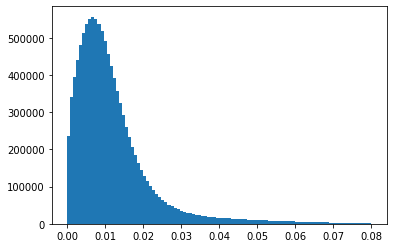

In [ ]:
w_ = w.detach().cpu().numpy()
np.save('smd10',w_)
lim = 0.1
import numpy as np
import matplotlib.pyplot as plt
wabs = np.abs(w_)
id = np.where(wabs <= lim)
w1 = wabs[id]
plt.hist(w1, bins=100)
plt.show()